# Forecasting XAU/USD Exchange Rates

## Introduction

### Background
The XAU/USD exchange rate represents the value of gold (XAU) in terms of the US Dollar (USD). Gold is a precious metal that has long been considered a safe-haven asset and is widely traded in the financial markets. Understanding and predicting movements in the XAU/USD exchange rate is of significant interest to investors, traders, and financial institutions.

### Project Objective
This project aims to leverage data science and predictive modeling techniques to forecast future XAU/USD exchange rates. By analyzing historical data and using machine learning algorithms, we intend to build a model that can provide valuable insights into potential price movements. This forecast can assist traders and investors in making informed decisions in the volatile world of financial markets.

### Dataset
We will utilize a historical dataset of XAU/USD exchange rates. The dataset includes:

- Date: The date of the exchange rate observation.
- Open Price: The opening price of XAU/USD on that date.
- Close Price: The closing price of XAU/USD on that date.
- High Price: The highest price reached during the day.
- Low Price: The lowest price reached during the day.
- Volume: The number of lots traded in a currency pair within a a day. In other words, the amount of currency bought and sold.

### Methodology
Our approach to forecasting XAU/USD exchange rates will involve the following steps:

1. Data Preprocessing: We will clean and prepare the dataset, handle missing values, and perform any necessary feature engineering.

2. Exploratory Data Analysis (EDA): We will visualize the data to gain insights into the historical trends, seasonality, and any potential patterns.

3. Feature Selection: We will select relevant features that are likely to have an impact on the exchange rate.

4. Model Selection: We will experiment with various machine learning algorithms such as time series models, regression models, and deep learning models to identify the most suitable approach for our forecasting task.

5. Model Training and Evaluation: We will train our chosen models on historical data and evaluate their performance using appropriate metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

6. Forecasting: We will use the trained model to make future predictions of XAU/USD exchange rates.

### Expected Outcomes
By the end of this project, we aim to have a reliable forecasting model that can provide short-term and long-term predictions of XAU/USD exchange rates. These predictions will be valuable for traders and investors looking to make data-driven decisions in the gold market.


In [14]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# Import required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os

# statistics
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [15]:
df1 = pd.read_csv('XAU_USD_Historical_Data_2000_2010.csv', parse_dates=[0])
df2 = pd.read_csv('XAU_USD_Historical_Data_2010_2023.csv', parse_dates=[0])

In [16]:
dfs = [df2, df1]
df = pd.concat(dfs)

In [17]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-01,"1,097.35","1,097.25","1,097.90","1,097.05",NaN,0.10%
1,2010-01-04,"1,120.40","1,096.25","1,123.80","1,093.45",NaN,2.10%
2,2010-01-05,"1,119.05","1,121.30","1,128.10","1,115.25",NaN,-0.12%
3,2010-01-06,"1,138.90","1,118.40","1,140.60","1,116.00",NaN,1.77%
4,2010-01-07,"1,132.30","1,138.20","1,139.15","1,128.60",NaN,-0.58%


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6168 entries, 0 to 2603
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      6168 non-null   datetime64[ns]
 1   Price     6168 non-null   object        
 2   Open      6168 non-null   object        
 3   High      6168 non-null   object        
 4   Low       6168 non-null   object        
 5   Vol.      0 non-null      float64       
 6   Change %  6168 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 385.5+ KB


#### We notice that:
- All nummerical various aren't treated as floats, because of the `,`
- Date should be treated as the index
- Vol. column looks suspicious, we need to investigate a bit more with it.
- Change % need to be float as well (remove `%`).

In [19]:
df.index = df.Date # here we changed the index

In [20]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2010-01-01,2010-01-01,"1,097.35","1,097.25","1,097.90","1,097.05",NaN,0.10%
2010-01-04,2010-01-04,"1,120.40","1,096.25","1,123.80","1,093.45",NaN,2.10%
2010-01-05,2010-01-05,"1,119.05","1,121.30","1,128.10","1,115.25",NaN,-0.12%
2010-01-06,2010-01-06,"1,138.90","1,118.40","1,140.60","1,116.00",NaN,1.77%
2010-01-07,2010-01-07,"1,132.30","1,138.20","1,139.15","1,128.60",NaN,-0.58%


In [21]:
df.drop('Date', inplace=True, axis=1) # dropped Date since it became the index

In [22]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-01-01,"1,097.35","1,097.25","1,097.90","1,097.05",NaN,0.10%
2010-01-04,"1,120.40","1,096.25","1,123.80","1,093.45",NaN,2.10%
2010-01-05,"1,119.05","1,121.30","1,128.10","1,115.25",NaN,-0.12%
2010-01-06,"1,138.90","1,118.40","1,140.60","1,116.00",NaN,1.77%
2010-01-07,"1,132.30","1,138.20","1,139.15","1,128.60",NaN,-0.58%


Next we're casting the types of the columns

In [23]:
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].map(lambda row : float(row.replace(',', '')))

In [24]:
df['Change %'] = df['Change %'].map(lambda x: float(x.replace('%', '')))

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6168 entries, 2010-01-01 to 2000-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     6168 non-null   float64
 1   Open      6168 non-null   float64
 2   High      6168 non-null   float64
 3   Low       6168 non-null   float64
 4   Vol.      0 non-null      float64
 5   Change %  6168 non-null   float64
dtypes: float64(6)
memory usage: 337.3 KB


Now all columns have the correct type.
Next we'll check whats wrong with `Vol.`

In [26]:
df['Vol.'].isna().sum()

6168

So the whole column is null, maybe the source doesn't have such data, or due to the decentralized and fragmented nature of the market, the lack of transparency, and the reliance on price-based indicators.

In [27]:
df.drop(columns=['Vol.'], inplace=True, axis=1) # We drop it 

In [28]:
df.head()

,Price,Open,High,Low,Change %
Date,,,,,
2010-01-01,1097.35,1097.25,1097.90,1097.05,0.10
2010-01-04,1120.40,1096.25,1123.80,1093.45,2.10
2010-01-05,1119.05,1121.30,1128.10,1115.25,-0.12
2010-01-06,1138.90,1118.40,1140.60,1116.00,1.77
2010-01-07,1132.30,1138.20,1139.15,1128.60,-0.58


We almost forgot to check if we have duplicates, let's see:

In [29]:
df.duplicated().sum()

1

In [30]:
df[df.duplicated()]

,Price,Open,High,Low,Change %
Date,,,,,
2010-01-01,1097.35,1097.25,1097.9,1097.05,0.1


It looks like both csv files had this record so that's why it got duplicated when we merged them.

In [31]:
df.index.is_monotonic_decreasing

False

In [32]:
df.index.is_monotonic_increasing

False

So the index isn't sorted

In [33]:
df = df.sort_index()

In [34]:
df.index.is_monotonic_increasing

True

## Correlation

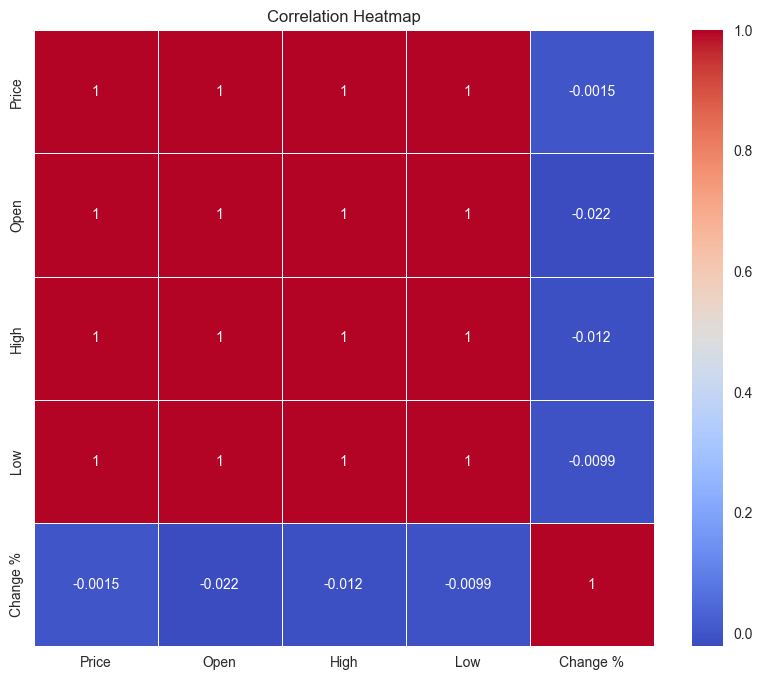

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the data
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


- As we can see, all of the features [] are highly correlated, so predicting one of them will be enough. So we'll just focus on the closing `Price`.
- Change percentage is originally based on today and yesterday price, we won't need it since in modelling we'll trying different values for lag so there's no need to include this derived value.


In [36]:
df = df['Price']

In [37]:
def display_plot(data, title):
    data.plot(
              figsize=(20,7),
              legend = True,
              alpha = 0.7,
             )
    plt.title(f'{title}', fontsize="xx-large")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize="xx-large")
    plt.show()

## Looking into data interval

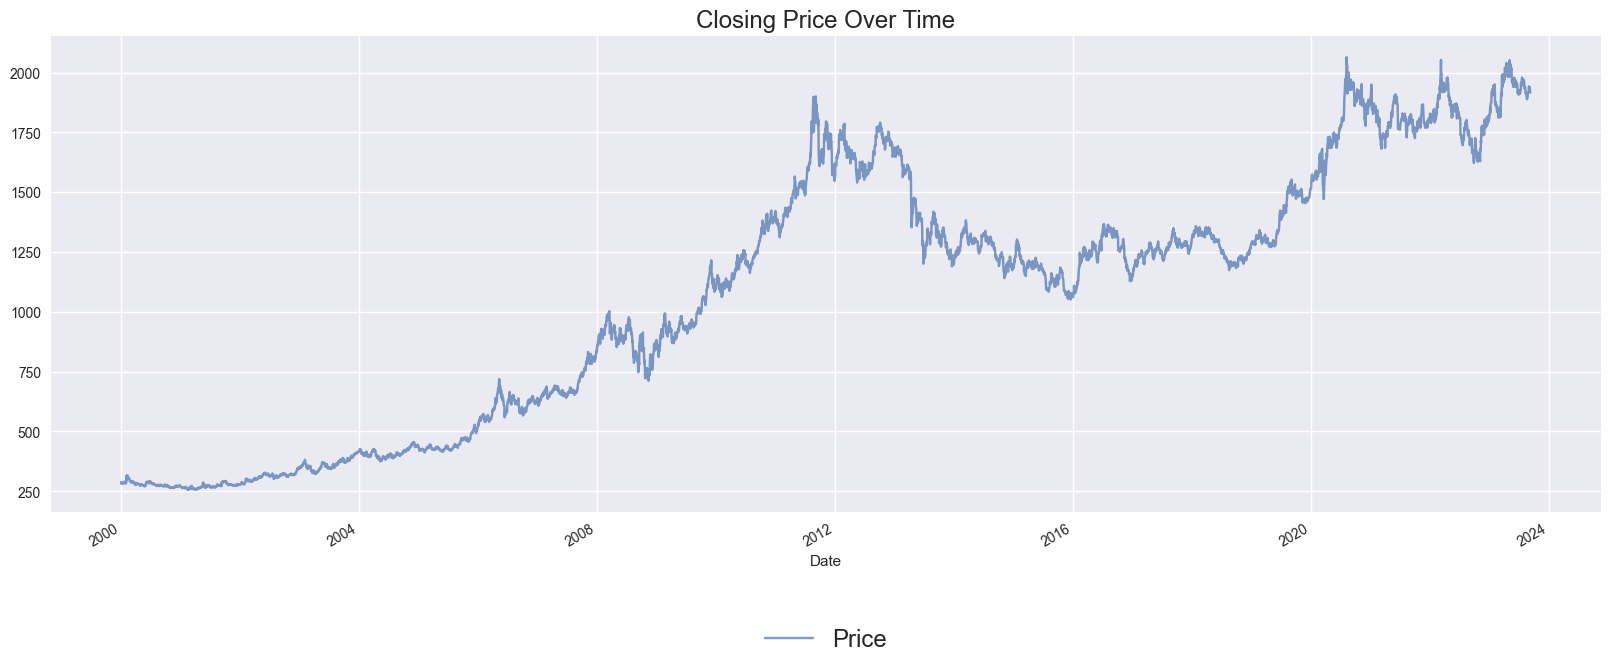

In [38]:
display_plot(df, 'Closing Price Over Time')

In [39]:
print(f"Max date: {df.index.max()}")
print(f"Min date: {df.index.min()}")

Max date: 2023-09-07 00:00:00
Min date: 2000-01-03 00:00:00


## Data Size and Range

The dataset we are working with spans a considerable 23-year range, which provides us with a substantial historical perspective on XAU/USD exchange rates. However, for the purposes of our analysis and forecasting, it's essential to consider the relevance of all this historical data.

## Excluding Expired Data

Given the extensive time frame, it's reasonable to assume that market conditions and dynamics may have significantly evolved over this period. Therefore, to ensure that our forecasting model is based on the most recent and relevant information, we plan to exclude expired data.

By "expired data," we refer to periods that are significantly distant in the past and may no longer be representative of current market conditions. Excluding such data can help us focus on recent trends and behaviors that are more likely to be informative for our forecasting model.

## So what range will we pick?

We can clearly see that the gold prices went wild the period after the financial crisis in 2008 till 2012, same thing happened in 2020 due to corona pendamic. So we'll consider using data after 2020 since it looks more relevant to todays prices and have similar characteristics 

In [40]:
df = df[df.index.year > 2020]

## Next we'll assess data completeness:

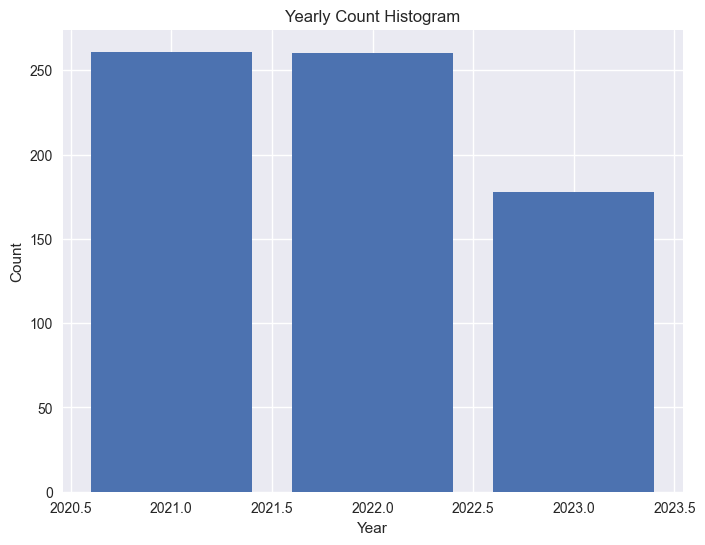

In [41]:
# Group by year and count occurrences
year_counts = df.index.year.value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Count Histogram')
plt.show()

In [42]:
year_counts

2021    261
2022    260
2023    178
Name: Date, dtype: int64

We can see that each year is missing about 100 days. which is approximately 2 days each week. After doing some resarch we found that gold does adhere to normal holiday market closures.

In [43]:
days_freq = df.index.day_of_week.value_counts().sort_index()
days_freq

0    140
1    140
2    140
3    140
4    139
Name: Date, dtype: int64

We clearly don't have any records in Saturdays and Sundays.

# Stationarity of XAU/USD Time Series

## Understanding Stationarity

Before diving into time series decomposition, it's crucial to assess the stationarity of the XAU/USD exchange rate data. Stationarity is a fundamental concept in time series analysis and refers to the statistical properties of a time series remaining constant over time. In essence, it means that the mean, variance, and autocorrelation structure of the data do not change with time.

## Importance of Stationarity

Why is stationarity important? Stationary time series data is easier to model and analyze because it exhibits consistent patterns and behaviors. Key advantages of working with stationary data include:

- **Predictability**: Stationary data tends to be more predictable, making it suitable for forecasting models.

- **Statistical Validity**: Many time series models assume stationarity for valid statistical inferences.

- **Simpler Models**: Stationary data often allows for the use of simpler models, leading to more interpretable results.


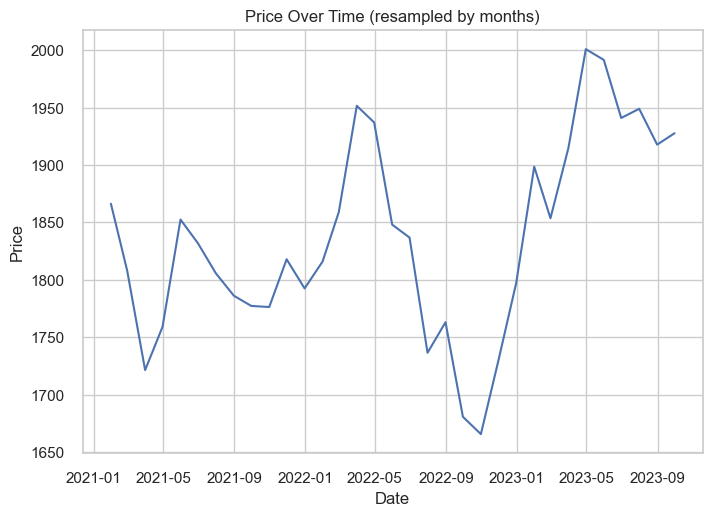

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

weekly_mean_close = df.resample('M').mean()

sns.set(style="whitegrid")

fig, ax = plt.subplots()

sns.lineplot(data=weekly_mean_close, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Price Over Time (resampled by months)")

plt.show()

The data has a very clear trend which is enough to classify this data as **non-stationary**, but as a bonus we'll try Augmented Dickey-Fuller Test (ADF) stationarity check:

In [45]:
from statsmodels.tsa.stattools import adfuller


def check_stationarity(series, name):
    
    result = adfuller(series.values)
    print(f'\n    Augmented Dickey-Fuller Test on {name}', "\n   ", '-'*40)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m    Stationary\u001b[0m")
    else:
        print("\x1b[31m    Non-stationary\x1b[0m")
    print('    ','-'*40)

In [46]:
check_stationarity(df, 'Price')


    Augmented Dickey-Fuller Test on Price 
    ----------------------------------------
ADF Statistic: -2.223123
p-value: 0.197960
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
    Non-stationary
     ----------------------------------------


So we'll make the data stationary then proceed with next steps, the first method we'll try is **differencing**:

In [47]:
df_diff = df.diff().dropna()

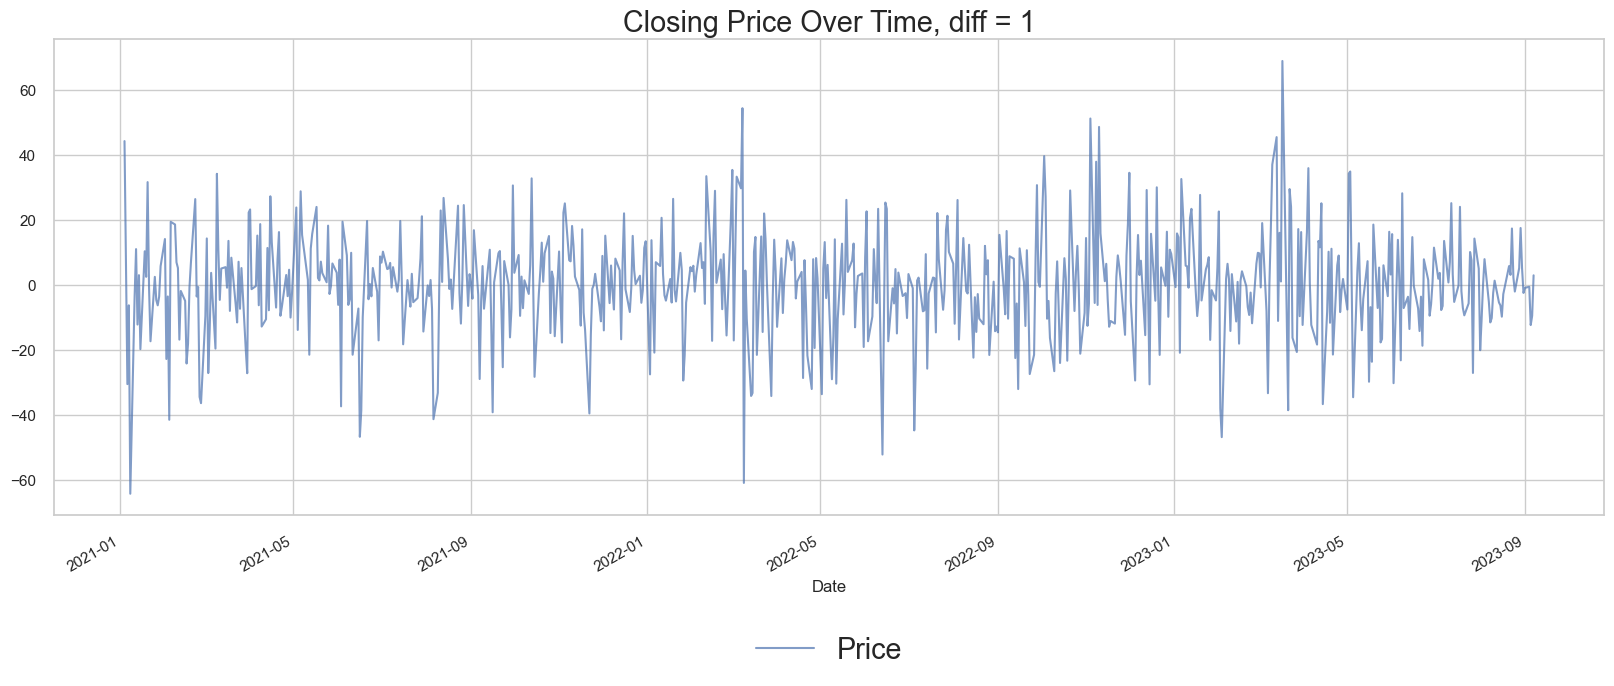

In [48]:
display_plot(df_diff, 'Closing Price Over Time, diff = 1')

Well now this looks more stationary-like, let's confirm it by using ADF statinarity check:

In [49]:
check_stationarity(df_diff, 'Price')


    Augmented Dickey-Fuller Test on Price 
    ----------------------------------------
ADF Statistic: -20.726672
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
    Stationary
     ----------------------------------------


# Time Series Decomposition

## Introduction to Decomposition

Time series decomposition is a fundamental technique used in the analysis of time-based data such as the XAU/USD exchange rates. It allows us to break down a time series into its underlying components, which often include:

1. **Trend Component**: This represents the long-term movement or trend in the time series. Identifying trends is crucial for understanding the overall direction in which the exchange rate is heading.

2. **Seasonal Component**: Many time series data, including financial data, exhibit repeating patterns or seasonality. The seasonal component captures these periodic fluctuations, such as daily, weekly, or yearly patterns.

3. **Residual (Error) Component**: The residual component represents the noise or randomness in the data that cannot be explained by the trend or seasonality. Analyzing the residuals can help us identify irregular or unexpected events.

## Purpose of Decomposition

In the context of our XAU/USD exchange rate data analysis, time series decomposition serves several important purposes:

- **Pattern Recognition**: It allows us to identify recurring patterns and trends within the exchange rate data, which can provide valuable insights for forecasting.

- **Anomaly Detection**: Decomposition helps in detecting unusual events or outliers in the data by comparing observed values to what is expected based on historical trends and seasonality.

- **Modeling**: The decomposed components can be used as inputs to various forecasting models, providing a more structured approach to time series forecasting.

- **Data Understanding**: By breaking down the data into its constituent parts, we gain a deeper understanding of the underlying dynamics of the XAU/USD exchange rate.

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_timeseries(sales, StoreType, period):

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(12)
    fig.set_figwidth(15)

    decomposition = seasonal_decompose(sales, model='additive', period=period)  # Set the specified period

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')

    plt.title(f'Decomposition Plots (Period={period})')  # Include the specified period in the title
    plt.show()


In [68]:
WORK_DAYS_PER_MONTH = 22

WORK_DAYS_PER_YEAR = 260

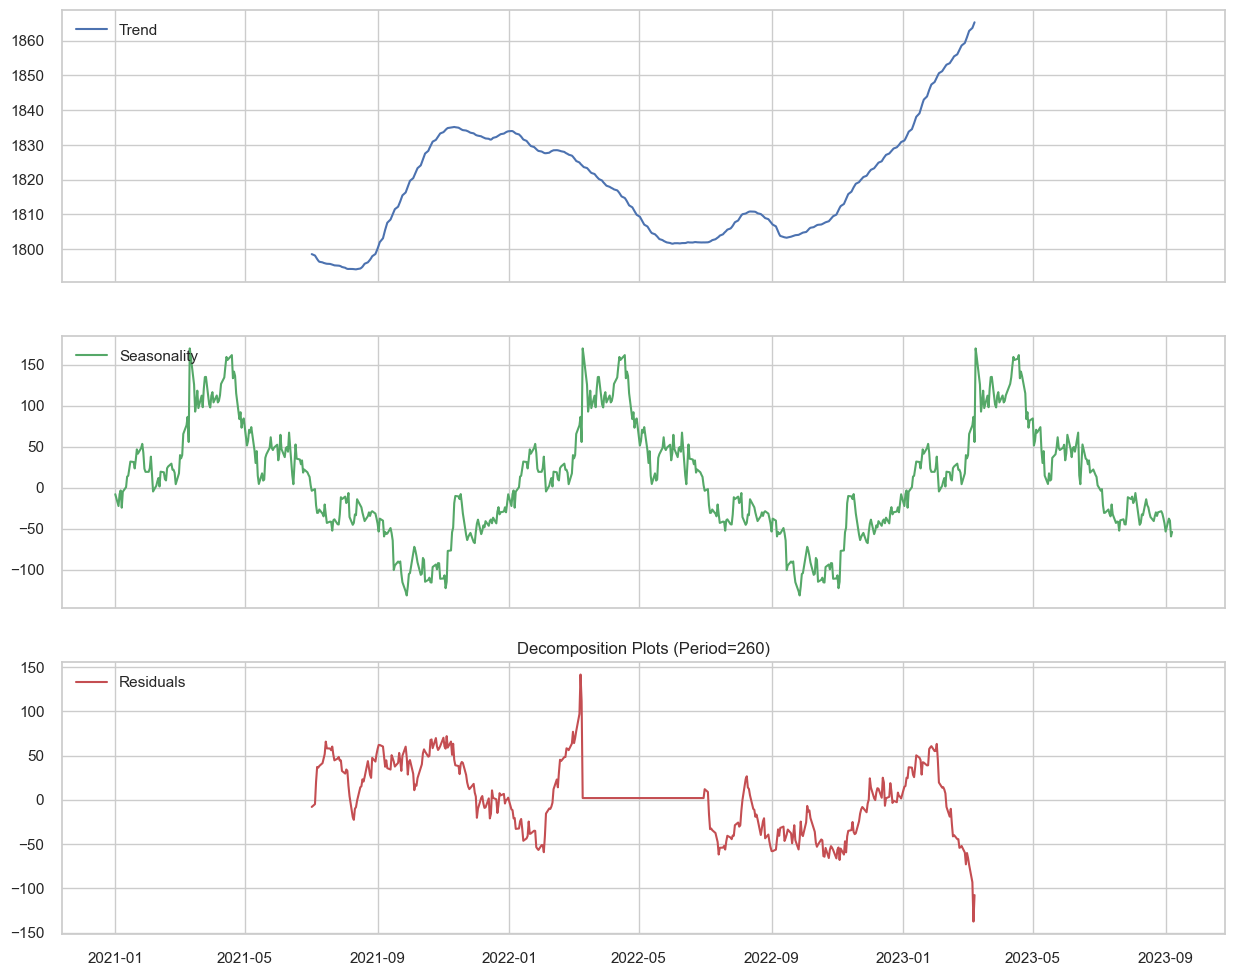

In [51]:
plot_timeseries(df,'Price', WORK_DAYS_PER_YEAR) # for one year

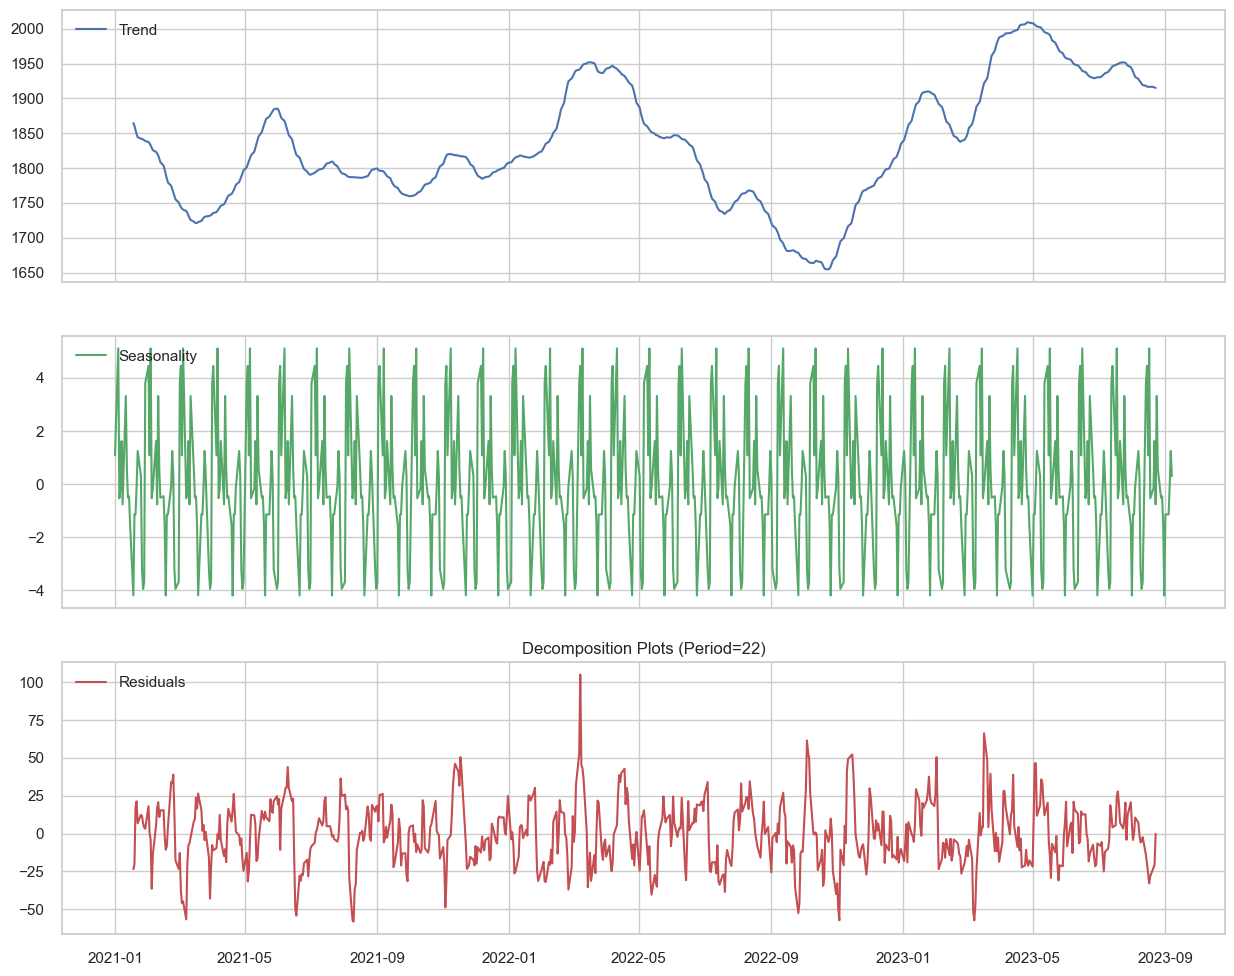

In [52]:
plot_timeseries(df,'Price', WORK_DAYS_PER_MONTH) # for one month 

The best season  we've observed is the yearly season, because the greatest seasonality range to trend range wsas observed when we took a period of one year (260 working days days), which means that the yearly season is more predictable. Also the residuals for the yearly season are closer to zero (more stable) that the monthly ones.

## Splitting the time series

In [53]:
test_date = '2023-06-01'
train, test = df[df.index < test_date], df[df.index >= test_date]
train.tail()

Date
2023-05-25    1940.34
2023-05-26    1946.33
2023-05-29    1942.84
2023-05-30    1959.14
2023-05-31    1962.30
Name: Price, dtype: float64

In [54]:
test.shape

(71,)

# Modelling


## ARIMA

AutoRegressive Integrated Moving Average (ARIMA) is a popular and powerful time series forecasting technique used to model and predict time-dependent data, such as the XAU/USD exchange rate in our case. ARIMA combines autoregressive (AR) and moving average (MA) components with differencing (I) to capture the underlying patterns and dynamics of a time series.

ARIMA models are characterized by three main parameters:

- **p (Autoregressive Order)**: The number of lag observations included in the model. It captures the relationship between the current value and previous values in the time series.

- **d (Differencing Order)**: The number of times differencing is applied to make the time series stationary. Differencing reduces trends and seasonality in the data.

- **q (Moving Average Order)**: The number of lagged forecast errors included in the model. It captures the relationship between the current value and past forecast errors.

## Steps in ARIMA Modeling

The process of building an ARIMA model typically involves the following steps:

1. **Data Preprocessing**: Prepare the time series data by ensuring it is stationary. This may involve differencing and other transformations.

2. **Model Identification**: Determine the values of p, d, and q by analyzing autocorrelation and partial autocorrelation plots, as well as using statistical tests like the AIC (Akaike Information Criterion).

3. **Model Evaluation**: Assess the model's performance using appropriate evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

4. **Model Forecasting**: Utilize the trained ARIMA model to make future predictions of the XAU/USD exchange rate.


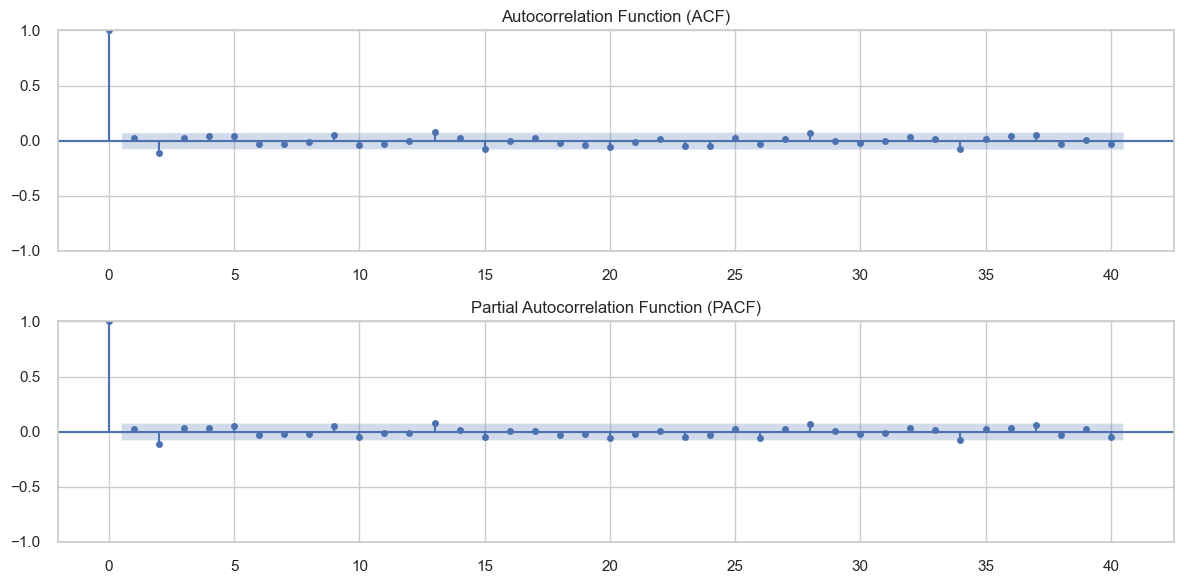

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_diff, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(df_diff, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


As we can observe, we got the the most significant spikes at p = 0, q = 0

In [43]:
p = 0
q = 0
d = 1 # needed to diff data once to make it stationary
seasonal_period = 12

In [44]:
# The following code could be used for grid search and estimating best params
p  = q = range(0, 1)
d = range(1,2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 260) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 1, 0) x (0, 1, 0, 260)


In [45]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(disp=False)

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 260) - AIC:3345.074721848606


We'll use the the order

In [ ]:
model_sarima = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 260),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit(disp=False)

print(results_sarima.summary().tables[1])

In [ ]:
test_predictions = results_sarima.forecast(len(test))
rmse = np.sqrt(mean_squared_error(test, test_predictions))

In [ ]:
print(rmse)

The RMSE is quite high :( let's plot it to see how it looks like

In [ ]:
df1 = pd.DataFrame(test)
test_predictions.index = test.index
df1['Predicted'] = test_predictions
df1.index = test.index
df1.head()

In [ ]:
display_plot(df1, 'actual vs predicted')

Well as we can see ARIMA didn't give us an acceptable solution, we'll move on to try another one for now. We may go back to ARIMA to try different parameters. 

## Time Series Modeling: LSTM (Long Short-Term Memory)

### Introduction to LSTM

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture specifically designed for sequential data, making it a powerful tool for time series forecasting. LSTM networks are capable of capturing complex temporal dependencies in data and have proven effective in various time series prediction tasks, including the XAU/USD exchange rate.

### Advantages of LSTM

- LSTMs excel at capturing complex temporal dependencies, making them suitable for time series data with nonlinear patterns.

- They can model sequences of varying lengths, accommodating irregular time intervals in the data.

- LSTMs are highly flexible and can be adapted to various forecasting tasks.

### Limitations of LSTM

- LSTM models may require a large amount of training data to perform well.

- They can be computationally expensive to train, especially with deep architectures.


In [55]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from numpy import array
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numpy import sqrt

# this method will be used to frou
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix >= len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

2023-09-25 17:50:37.455595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 17:50:37.962384: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 17:50:37.964504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 17:50:40.833517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [56]:
scaler = PowerTransformer()
data = df.to_frame().values
data = scaler.fit_transform(data)

y_scaler = PowerTransformer()
y_prime = df.values.reshape(-1, 1)
y_prime = y_scaler.fit_transform(y_prime)

In [57]:
# choose a number of time steps
n_steps = 5

In [58]:
# convert into input/output
X, y = split_sequences(data, n_steps)

In [59]:
X_train, X_test =X[:-60], X[-60:]
y_train, y_test =  y[:-60], y[-60:]

In [60]:
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(40, activation='sigmoid', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='RMSprop', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit model
model.fit(X_train, y_train, epochs=500,batch_size=32, verbose=0)
# demonstrate prediction
model.summary()

2023-09-25 17:50:43.983467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-25 17:50:43.985820: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [61]:
test = []
for i in range(60):

    test.append(X_test[i])

yhat = model.predict(array(test), verbose=0)
prediction = []
for i in range(60):

    prediction.append(yhat[i][0])

In [62]:
mae = mean_absolute_error(y_test, prediction)
rmse = sqrt(mean_squared_error(y_test, prediction))
print('MAE before inverse Scaling: %f' % mae)
print('RMSE before inverse Scaling: %f' % rmse)

y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test = [ '%.1f' % y for y in y_test ]
y_test = [float(i) for i in y_test]
predict = y_scaler.inverse_transform(array(prediction).reshape(-1, 1))
predict = [ '%.3f' % y for y in predict ]
predict = [float(i) for i in predict]

MAE before inverse Scaling: 0.078410
RMSE before inverse Scaling: 0.102979


MAE after inverse scaling: 7.482450
RMSE after inverse scaling: 9.851521


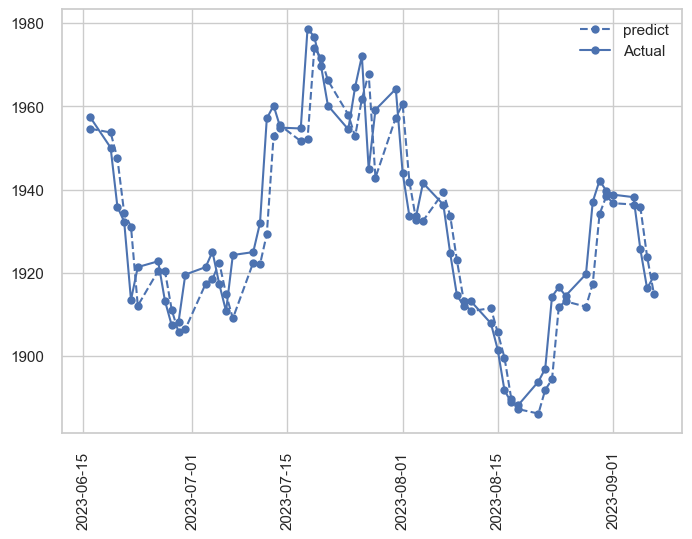

In [66]:
x = pd.DataFrame(df.index[-60:]).values

mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mean_squared_error(y_test, predict))
print('MAE after inverse scaling: %f' % mae)
print('RMSE after inverse scaling: %f' % rmse)

plt.plot(x, predict,'--bo', label = "predict",linestyle = 'dashed')
plt.plot(x, y_test,marker='o', label = "Actual")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [67]:
model.save('./models/lstm-forecaster.h5')

## Conclusion:
In this model we tried to make predictions for gold price depending on historical data. We tried different models for this purpose like ARIMA and LSTM, comparing the results of these models we noticed that lstms has a better performance. 
Now we have a promsing model that we can use in the E2E website. For now it only predicts the gold price for one day only, the next step is making it suitable for predicting longer intervals and defining the corresponding pipelines.